##### In this notebook we consider different feature sets (pos-tags, function words, and a combination thereof) for predicting author gender and topic of master theses. We plot the PCA components of the features of each thesis reveal find patterns regarding gender and topic #####


In [10]:
lang = 'en'
word_kind = 'word'
tag_kind = 'pos'

In [11]:
import json
import pandas as pd

In [12]:
# Load the downsampled data and precomputed frequencies
df    = pd.read_csv(f"data/theses-{lang}-downsampled.csv")
freqs = pd.read_csv(f"data/frequencies-{lang}-{word_kind}-{tag_kind}.csv")

# Drop junk columns and duplicates
df   .drop(['Unnamed: 0'], axis=1, inplace=True)
freqs.drop(['Unnamed: 0'], axis=1, inplace=True)
freqs.drop_duplicates(subset=['ID'], inplace=True)

ids = freqs['ID'].values

with open(f"data/vocab-{lang}-{word_kind}-{tag_kind}.txt") as fil:
    metadata = json.loads(fil.readline())
print(metadata)

{'words': 164, 'unigrams': 59, 'bigrams': 100, 'trigrams': 500}


In [13]:
df[:2]

,id,handle,title,authors,department,date,language,abstract,degree,links,keywords,faculty,year,inferred,text,gender_composition,type,topic
0,1555,http://hdl.handle.net/2077/1423,Obstacles of growth in SME´s -What do the obst...,"['Sjögren, Eva-Lena', 'Bäcktorp, Pia']",Företagsekonomiska institutionen,2006,en,Background and problem: Growth has recently be...,C,['https://gupea.ub.gu.se/bitstream/2077/1423/1...,NaN,Handelshögskolan,2006.0,"{'gender': 'female', 'language': 'en'}",5/1555.txt.gz,female,NaN,ekonomi
1,1571,http://hdl.handle.net/2077/1439,Implementation of the International Financial ...,"['Petrovets, Valeria']",Företagsekonomiska institutionen,2006,en,Background and problem: After the break up of ...,C,['https://gupea.ub.gu.se/bitstream/2077/1439/1...,NaN,Handelshögskolan,2006.0,"{'gender': 'female', 'language': 'en'}",1/1571.txt.gz,female,NaN,ekonomi


In [14]:
freqs[:2]

,ID,aboard,about,above,across,after,against,albeit,all,along,...,VVN+IN+VVG,VVN+NN+IN,VVN+SENT+?,VVN+TO+DT,VVN+TO+VV,VVP+DT+NN,VVZ+DT+JJ,VVZ+DT+NN,VVZ+IN+DT,WRB+DT+NN
0,50905,0.0,0.005394,0.001079,0.000360,0.003955,0.000719,0.0,0.005034,0.000000,...,0.000686,0.000153,0.001831,0.000915,0.000610,0.000458,0.000305,0.001068,0.000381,0.000229
1,300797,0.0,0.001187,0.000791,0.010289,0.003562,0.000396,0.0,0.007123,0.001187,...,0.000567,0.000284,0.000709,0.000496,0.000851,0.000709,0.000496,0.000993,0.000567,0.000567


In [15]:
a, b, c, d = metadata['words'], metadata['unigrams'], metadata['bigrams'], metadata['trigrams']
funword_frequencies = freqs.iloc[:,       1 : a+1]
unigram_frequencies = freqs.iloc[:,     a+1 : a+b+1]
bigram_frequencies  = freqs.iloc[:,   a+b+1 : a+b+c+1]
trigram_frequencies = freqs.iloc[:, a+b+c+1 : a+b+c+d+1]

In [16]:
from util import genders, topics, gender_to_int, topic_to_int

labels_gender = [gender_to_int(df[df['id'] == ident]['gender_composition'].values[0]) for ident in ids]
labels_topic  = [topic_to_int(df[df['id'] == ident]['topic'].values[0]) for ident in ids]

gender_distribution = {
    gen: sum(g == gender_to_int(gen) for g in labels_gender)
    for gen in genders
}
topic_distribution = {
    top: sum(t == topic_to_int(top) for t in labels_topic)
    for top in topics
}

print("Genders:", gender_distribution)
print("Topics:", topic_distribution)

Genders: {'female': 1973, 'male': 1973}
Topics: {'humaniora': 354, 'arkitektur': 1694, 'ekonomi': 622, 'naturvetenskap': 1276}


In [17]:
 # multiply bigrams by 2 and trigrams by 4, according to Koppel paper
def mult(n,lst) : 
    return [n*k for k in lst]

from collections import defaultdict
inputs = defaultdict(list)

for i in range(len(freqs)): 
    funs = list(funword_frequencies.iloc[i])
    unis = list(unigram_frequencies.iloc[i])
    bis  = list(bigram_frequencies.iloc[i])
    tris = list(trigram_frequencies.iloc[i])
    inputs['All features (Koppel)'].append(mult(1,funs) + mult(1,unis) + mult(2,bis) + mult(4,tris))
    inputs['All POS features (Koppel)'].append(mult(1,unis) + mult(2,bis) + mult(4,tris))
    inputs['All features'].append(funs + unis + bis + tris)
    inputs['All POS features'].append(unis + bis + tris)
    inputs['Function words'].append(funs)
    inputs['POS unigrams'].append(unis)
    inputs['POS bigrams' ].append(bis)
    inputs['POS trigrams'].append(tris)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    list(range(len(freqs))),
    list(zip(labels_topic, labels_gender)),
    test_size=0.25, 
    random_state=42
)
print("Train:", len(X_train), "; test: ", len(X_test))

Train: 2959 ; test:  987


In [19]:
from sklearn.decomposition import PCA

# Initialize, fit and transform PCA model on the training data, for each mode
pcas_transformed = {}
for mode, inp in inputs.items():
    pca = PCA(n_components=2)
    pca.fit(inp)
    pcas_transformed[mode] = pca.transform(inp)

In [20]:
import matplotlib.pyplot as plt

def plot_pca(title, x, y, labels, labelnames): 
    plt.title(title)
    scatter = plt.scatter(x,y,
        c = labels, edgecolor='none', alpha=0.6,
        cmap = plt.cm.get_cmap('rainbow', len(labels)))
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend(handles=scatter.legend_elements()[0], labels=labelnames)

#### Plot the PCA components of the data for each feature set (function words, pos-tags, and both), and color by gender and topic. ####

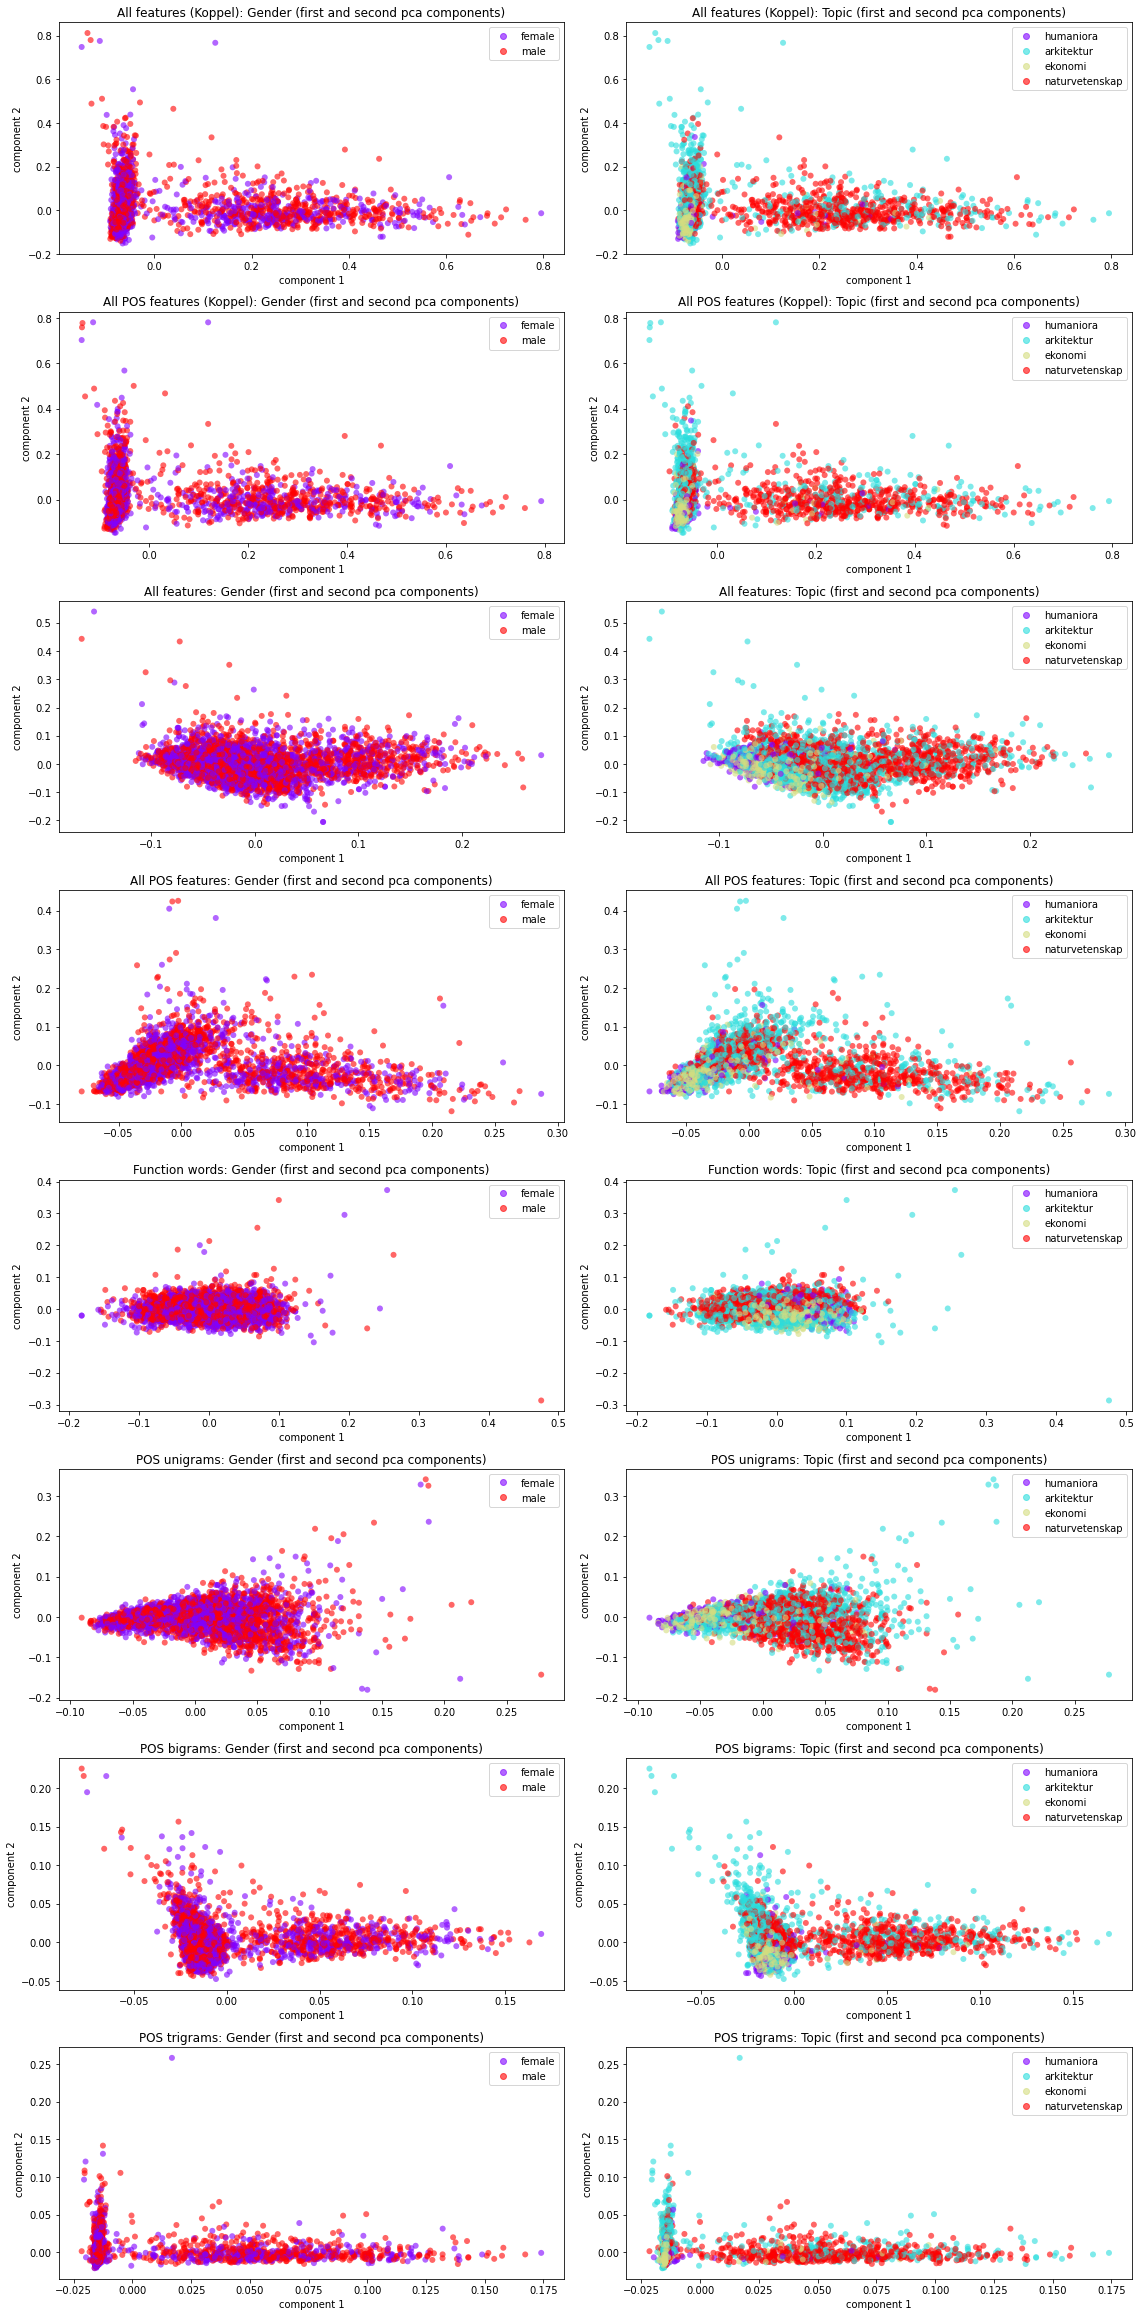

In [21]:
# Plot the components
from util import genders, topics

fig = plt.figure(figsize=(16,64))
plotsize = 2 * len(pcas_transformed)
for k, (mode, pca) in enumerate(pcas_transformed.items()):
    plt.subplot(plotsize, 2, 2*k + 1)
    plot_pca(f"{mode}: Gender (first and second pca components)", pca[:,0], pca[:,1], labels_gender, genders)
    plt.subplot(plotsize, 2, 2*k + 2)
    plot_pca(f"{mode}: Topic (first and second pca components)", pca[:,0], pca[:,1], labels_topic, topics)

plt.tight_layout()
plt.show()

#### Plot the PCA components of the theses for each feature set, separately for each topic, and color by gender ####

In [22]:
import matplotlib.pyplot as plt
from util import genders, topics, int_to_topic, topic_to_int

indices = {
    top: [i for i, x in enumerate(labels_topic) if x == topic_to_int(top)]
    for top in topics
}
train_labels = {
    top: [labels_gender[i] for i in indices[top]] 
    for top in indices
}

def plot_each_faculty(top):
    plt.figure(figsize=(16,24))
    plotsize = len(pcas_transformed)
    for k, (mode, pca) in enumerate(pcas_transformed.items(), 1):
        plt.subplot(plotsize, 4, k)
        plt.title(f"{top}\n{mode}")
        scatter1 = plt.scatter(pca[indices[top],0], pca[indices[top],1],
                               c=train_labels[top], edgecolor='none', alpha=0.7,
                               cmap=plt.cm.get_cmap('rainbow', 3))
        plt.xlabel('PCA component 1')
        plt.ylabel('PCA component 2')
        plt.legend(handles=scatter1.legend_elements()[0], labels=genders)

    plt.tight_layout()
    plt.show()

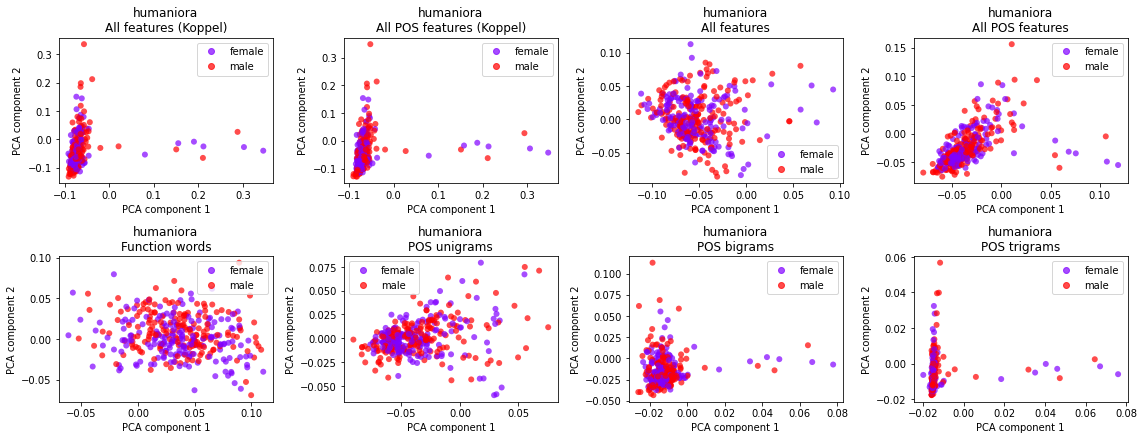

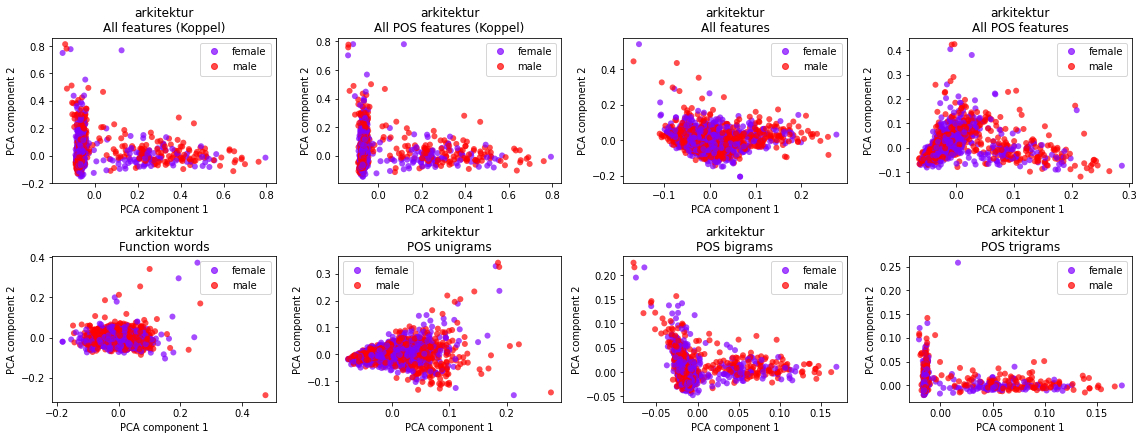

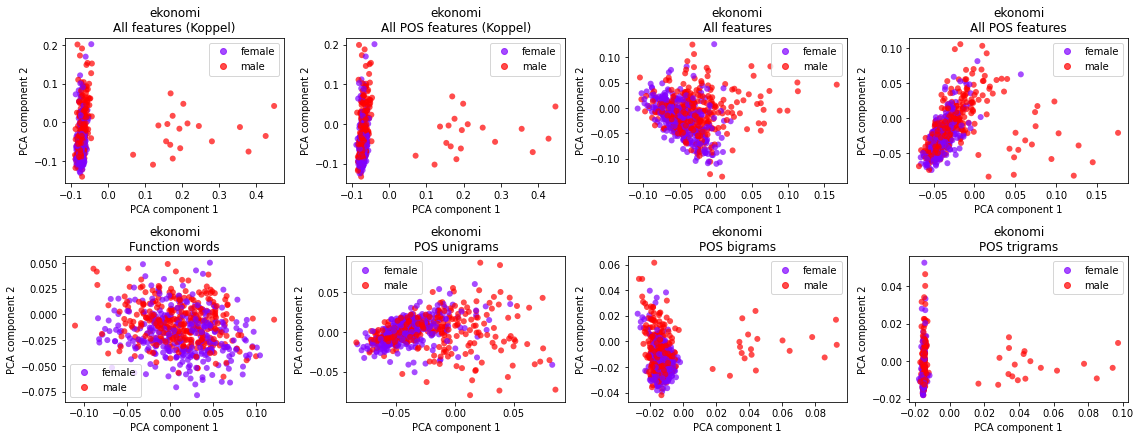

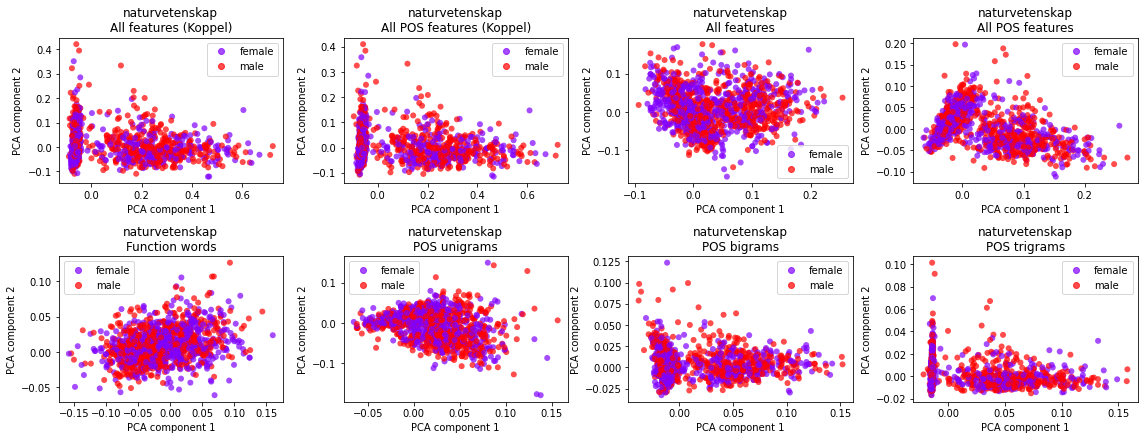

In [23]:
for top in topics: 
    plot_each_faculty(top)

### Classification

In [24]:
from sklearn.linear_model import LogisticRegression
def logreg(): 
    return LogisticRegression(solver='saga', penalty = 'l1', max_iter=1000)

In [25]:
logreg_all = logreg()

In [26]:
# Fit a logistic regression model on the frequency matrix and gender labels of each topic 
logreg_all.fit(freqs, labels_gender)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [27]:
from sklearn.metrics import classification_report
def print_report(model, kind, genders, frequencies):
    classification_report(genders[i],model.predict(frequencies[i]),labels=[0,1],target_names=['female','male'])